Stock data for AAPL loaded successfully.
States assigned based on quantiles.
Stationary distribution calculated.


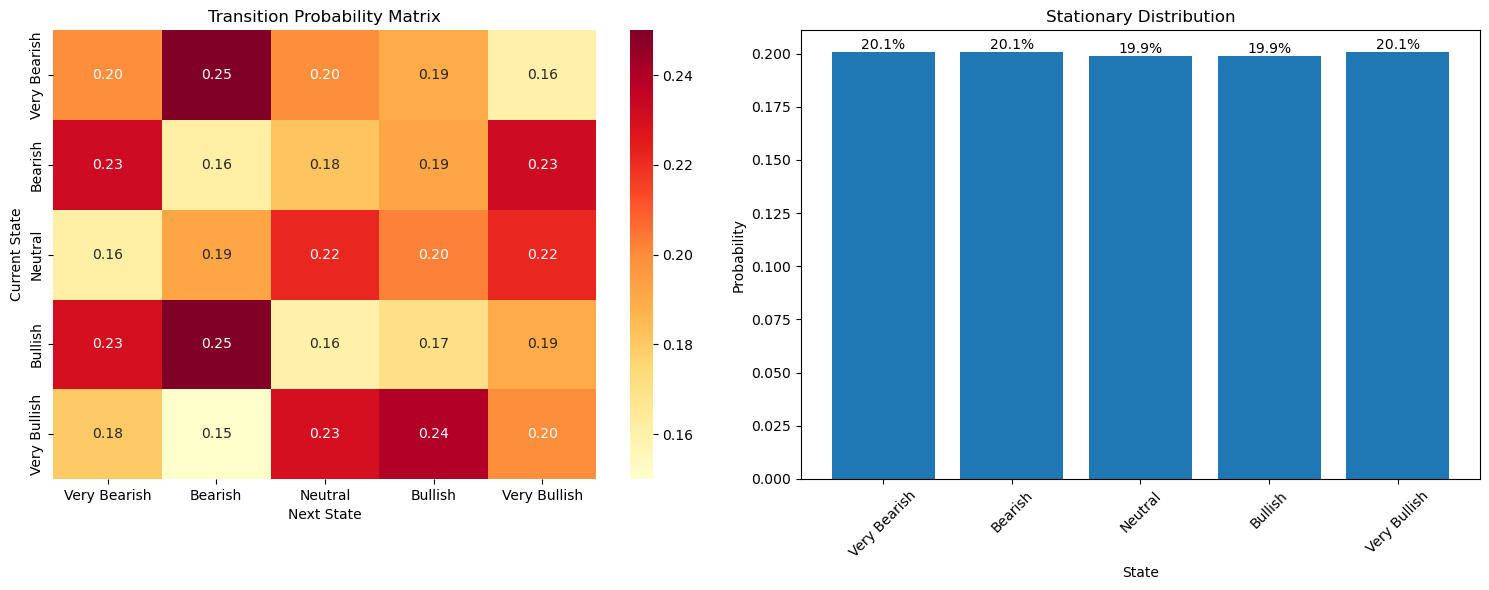


Markov Chain Analysis Complete.

Transition Matrix:
              Very Bearish   Bearish   Neutral   Bullish  Very Bullish
Very Bearish      0.200000  0.250000  0.200000  0.190000      0.160000
Bearish           0.232323  0.161616  0.181818  0.191919      0.232323
Neutral           0.161616  0.191919  0.222222  0.202020      0.222222
Bullish           0.230000  0.250000  0.160000  0.170000      0.190000
Very Bullish      0.180000  0.150000  0.230000  0.240000      0.200000

Stationary Distribution:
          State  Probability
0  Very Bearish     0.200800
1       Bearish     0.200630
2       Neutral     0.198844
3       Bullish     0.198843
4  Very Bullish     0.200883
Mean return times: 
 [4.98007374 4.98429459 5.02907491 5.0291058  4.97801382]
Performed 1000 simulations for 100 days.
Current price is : 243.36000061035156


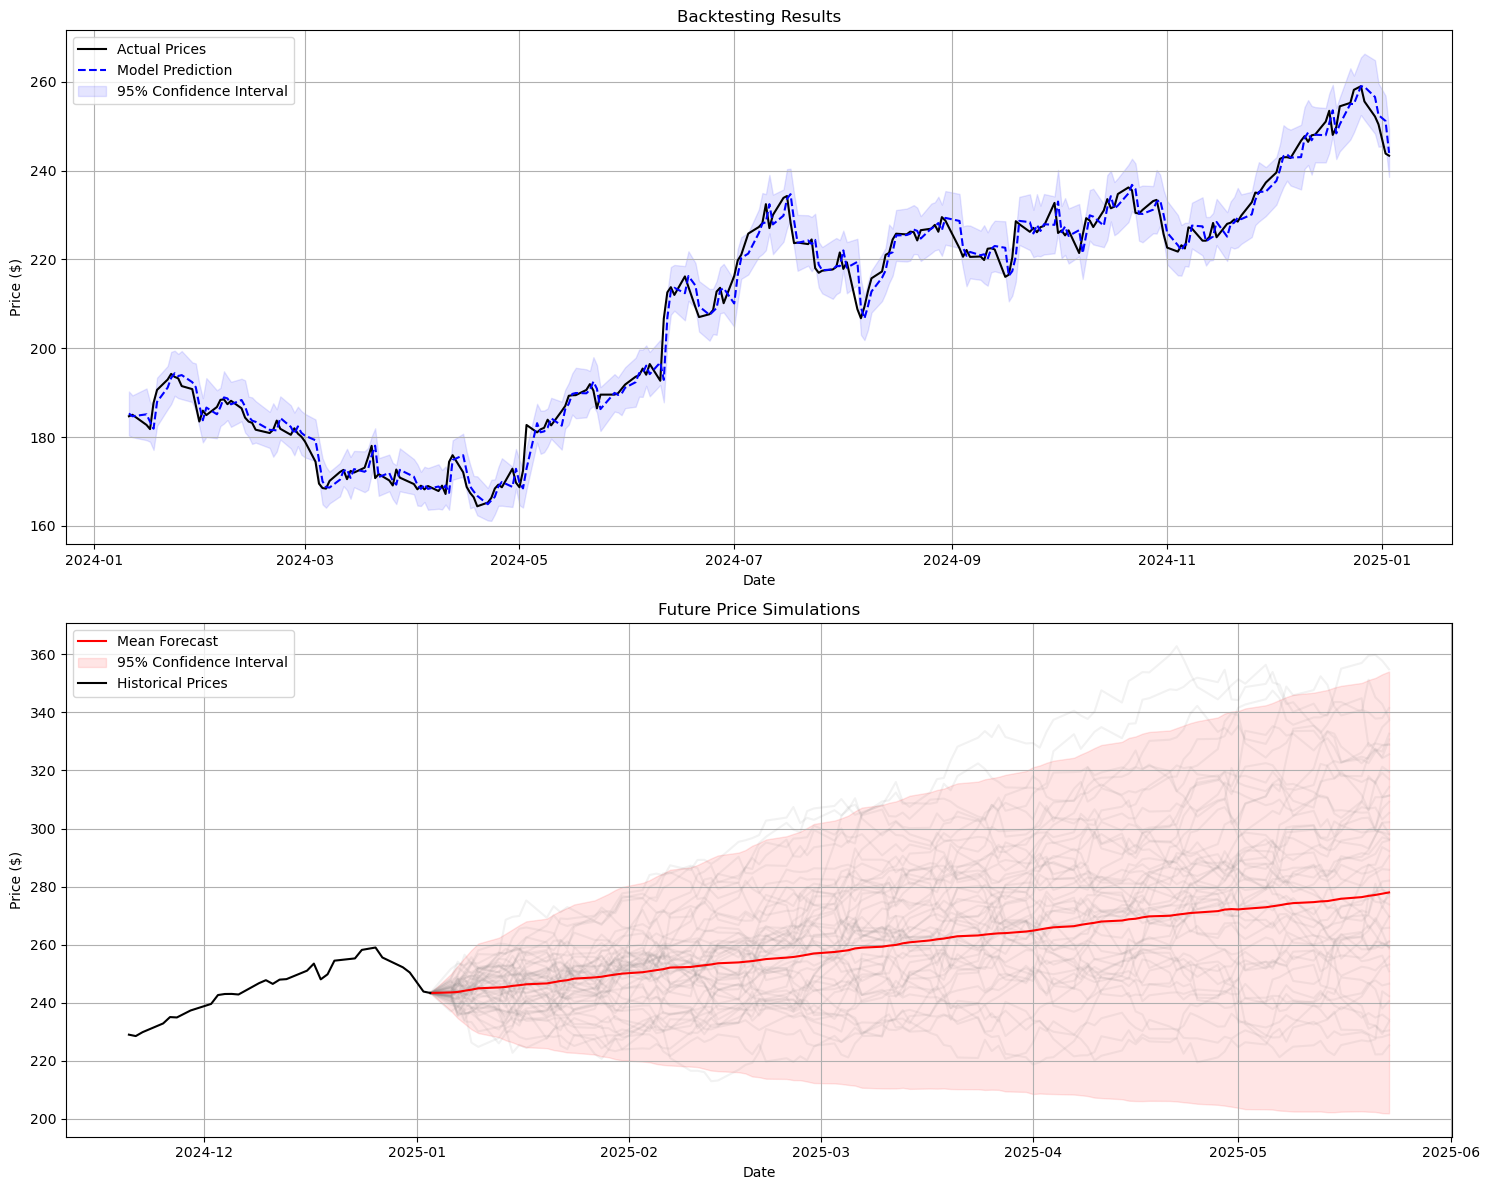


Future Prediction Statistics:
+---------------------------------------+-------------------+
| Metric                                | Value             |
|---------------------------------------+-------------------|
| Current Price                         | $243.36           |
| Predicted Price (in 100 days)         | $278.00           |
| Average Predicted Price (100 days)    | $278.00           |
| Prediction Range                      | $171.40 - $457.57 |
| Historical Volatility (%)             | 1.34%             |
| Simulated Volatility (%)              | 10.78%            |
| 90% Confidence Interval (Final Price) | $219.51 - $346.87 |
| 95% Confidence Interval (Final Price) | $211.70 - $362.81 |
+---------------------------------------+-------------------+
MAE for last 30 days: 27.91983655289595
RMSE for the last 30 days: 29.172652633740302


In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from scipy import linalg
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate



class StockDataAnalysis:
    def __init__(self, ticker, start_date, end_date, n_states=5):
        """
        Initialize the StockDataAnalysis with stock parameters and state count.
        
        Args:
            ticker (str): Stock ticker symbol.
            start_date (datetime): Start date for data retrieval.
            end_date (datetime): End date for data retrieval.
            n_states (int): Number of quantile-based states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.transition_matrix = None

    def get_stock_data(self):
        """
        Download historical stock data from Yahoo Finance and preprocess it.
        """
        stock = yf.Ticker(self.ticker)
        df = stock.history(start=self.start_date, end=self.end_date)
        df['Daily_Return'] = df['Close'].pct_change() * 100 #TODO Extract the close price and calculate daily returns
        self.df = df.dropna()   #TODO Remove NaN values
        print(f"Stock data for {self.ticker} loaded successfully.")

    def assign_states(self):
        """
        Assign states based on return quantiles and add descriptive labels.
        """
        self.df['State'] = pd.qcut(self.df['Daily_Return'], q=self.n_states, labels=False)
        state_labels =  ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"] #TODO Initialize state lables in a list in the order described in the question
        self.df['State_Description'] = pd.Categorical(
            [state_labels[int(i)] for i in self.df['State']]
        )
        print("States assigned based on quantiles.")

    def get_transition_matrix(self):
        """
        Construct the transition probability matrix from the sequence of states.
        
        Returns:
            np.array: Transition matrix (dimensions: n_states x n_states).
        
        TODO:
        - Ensure that states are properly handled as integers without NaNs.
        - Implement a loop or vectorized operation to count transitions between states.
        - Normalize the rows of the transition matrix to get probabilities.
        """
        # TODO: Extract the 'State' column from the DataFrame as a numpy array.
        states = self.df['State'].values.astype(int) # Ensure this is done without NaNs if needed.

        # Initialize a matrix to store transition counts.
        transitions = np.zeros((self.n_states, self.n_states)) 

        # TODO: Iterate through the array of states and populate the transition matrix.
        # Hint: Use a loop to increment the count for transitions from states[i] to states[i + 1].
        for i in range(len(states) - 1):
            current_state = states[i]  # Ensure valid integer index
            next_state = states[i+1]  # Ensure valid integer index
            transitions[current_state][next_state] += 1  # Increment the count for observed transitions.

        
        epsilon = 1e-8
        row_sums = transitions.sum(axis=1) + epsilon

        # TODO: Normalize each row of the transition matrix to create probabilities.
        # Hint: Divide each element in a row by the sum of the row to ensure each row sums to 1.
        self.transition_matrix =  transitions / (transitions.sum(axis=1, keepdims=True) + epsilon)

        return self.transition_matrix


    def get_stationary_distribution(self):
        """
        Calculate the stationary distribution of the Markov chain.
        
        Returns:
            np.array: Stationary distribution (dimensions: n_states).
        """
        eigenvals, eigenvects = np.linalg.eig(self.transition_matrix.T) # TODO Calculate the eigenvalues and eigenvectors
        stationary = eigenvects[:, np.where(np.isclose(eigenvals, 1))[0][0]].real
        stationary = stationary / stationary.sum() #TODO Normalize the stationary distribution
        print("Stationary distribution calculated.")
        return stationary

    def analyze_markov_chain(self):
        """
        Analyze and visualize Markov chain properties.
        """
        stationary_dist = self.get_stationary_distribution() # TODO Calculate the stationary distribution
        state_labels = ["Very Bearish", "Bearish", "Neutral", "Bullish", "Very Bullish"] #TODO Initialize state lables in a list in the order described in the question

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        sns.heatmap(self.transition_matrix, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax1,
                    xticklabels=state_labels, yticklabels=state_labels)
        ax1.set_title('Transition Probability Matrix')
        ax1.set_xlabel('Next State')
        ax1.set_ylabel('Current State')

        bars = ax2.bar(state_labels, stationary_dist)
        ax2.set_title('Stationary Distribution')
        ax2.set_xlabel('State')
        ax2.set_ylabel('Probability')
        ax2.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width() / 2., height,
                     f'{height * 100:.1f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        print("\nMarkov Chain Analysis Complete.")
        print("\nTransition Matrix:")
        transition_df = pd.DataFrame(self.transition_matrix,
                                     columns=state_labels,
                                     index=state_labels)
        print(transition_df)

        print("\nStationary Distribution:")
        stationary_df = pd.DataFrame({
            'State': state_labels,
            'Probability': stationary_dist
        })
        print(stationary_df)
        print(f'Mean return times: \n {1/stationary_dist}')
        
    
    def simulate_price_path(self, initial_price, days):
        """
        Simulate a single price path using the Markov chain model.
        
        Args:
            initial_price (float): Starting price for the simulation.
            days (int): Number of days to simulate.
        
        Returns:
            np.array: Simulated price path.
        
        TODO:
        - Implement the logic for price path simulation based on state transitions.
        """
        prices = [initial_price]
        current_state = np.random.choice(self.n_states)

        for _ in range(days):
            next_state = np.random.choice(self.n_states, p=self.transition_matrix[current_state])
            return_pct = np.random.choice(self.df[self.df['State'] == next_state]['Daily_Return'])
            next_price = prices[-1] * (1 + return_pct / 100)
            prices.append(next_price)
            current_state = next_state

        return np.array(prices)

    def perform_simulations(self, n_simulations=1000, forecast_days=100):
        """
        Perform multiple price simulations using the Markov model.
        
        TODO:
        - Store and return simulation results.
        """
        initial_price = self.df['Close'].iloc[-1] 

        simulations = np.zeros((n_simulations, forecast_days + 1))

        for i in range(n_simulations):
            simulations[i] =self.simulate_price_path(initial_price, forecast_days) #TODO call the simulate_price_path method

        print(f"Performed {n_simulations} simulations for {forecast_days} days.")
        return simulations

    def backtest(self,df, transition_matrix, n_simulations=100):
        """
        Perform walk-forward backtesting using the Markov model.
        
        TODO:
        - Implement rolling window logic to create a dynamic transition matrix for each backtest step.
        - Ensure return distributions are created for each state within the rolling window.
        - Simulate next-day prices using the dynamic transition matrix and return distributions.
        """
        window_size = 252  # One trading year
        n_states = transition_matrix.shape[0]
        predictions = np.zeros((len(df), n_simulations))

        # TODO: Iterate through the dataset, starting from the end of the initial rolling window.
        for i in range(window_size, len(df)):
            # TODO: Extract a rolling window of the data to calculate the transition matrix.
            # Hint: Use `iloc` to get rows from `i - window_size` to `i`.
            window_data = self.df.iloc[i - window_size:i]  

            # Check if the window data has enough valid states to build a transition matrix.
            if window_data['State'].isna().any() or len(window_data['State'].unique()) < n_states:  # Replace with a condition to check for data sufficiency.
                continue

            # TODO: Create a transition matrix from the rolling window data.
            # Hint: Call a function like `get_transition_matrix` with the states in `window_data`.
            window_transitions = self.get_transition_matrix()  

            # Create return distributions for each state, ensuring non-empty arrays
            returns_by_state = [
               window_data[window_data['State'] == state]['Daily_Return'].values
                for state in range(n_states)
            ]

            # TODO: Simulate next-day prices using the current price and the transition matrix.
            # Hint: Use `simulate_price_path` for the simulation.
            current_price = df['Close'].iloc[i - 1]
            for sim in range(n_simulations):
                sim_path = self.simulate_price_path(current_price, 1)  
                predictions[i, sim] = sim_path[-1]  

        # TODO: Return or process the predictions as needed for analysis.
        valid_indices = np.where(predictions.sum(axis=1) != 0)[0]
        prediction_mean = np.mean(predictions[valid_indices], axis=1)
        prediction_std = np.std(predictions[valid_indices], axis=1)
        lower_bound = prediction_mean - 1.96 * prediction_std
        upper_bound = prediction_mean + 1.96 * prediction_std

        return prediction_mean, lower_bound, upper_bound


    def plot_results(self,df, simulations, backtest_results):
        """
        Create visualization of historical prices, backtest results, and future simulations.
        """
        prediction_mean, lower_bound, upper_bound = backtest_results
        
        # Adjust the prediction arrays to match the index length
        valid_index = len(prediction_mean)
        df_index_subset = df.index[-valid_index:]  # Ensure the x-axis matches the length of the prediction arrays
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Plot backtesting results
        ax1.plot(df_index_subset, df['Close'].iloc[-valid_index:], color='black', label='Actual Prices')
        ax1.plot(df_index_subset, prediction_mean, color='blue', linestyle='--', label='Model Prediction')
        ax1.fill_between(df_index_subset, lower_bound, upper_bound, color='blue', alpha=0.1, label='95% Confidence Interval')
        ax1.set_title('Backtesting Results')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True)

        # Plot future simulations
        future_dates = pd.date_range(
            df.index[-1], 
            periods=simulations.shape[1],
            freq='B'
        )
        
        # Plot individual simulations
        for sim in simulations[:50]:  # Plot first 50 simulations for clarity
            ax2.plot(future_dates, sim, alpha=0.1, color='gray')
        
        # Plot confidence intervals for simulations
        sim_mean = np.mean(simulations, axis=0)
        sim_std = np.std(simulations, axis=0)
        ax2.plot(future_dates, sim_mean, color='red', label='Mean Forecast')
        ax2.fill_between(
            future_dates,
            sim_mean - 1.96 * sim_std,
            sim_mean + 1.96 * sim_std,
            color='red', alpha=0.1,
            label='95% Confidence Interval'
        )
        
        # Plot historical prices for context
        ax2.plot(df.index[-30:], df['Close'][-30:], color='black', label='Historical Prices')
        
        ax2.set_title('Future Price Simulations')
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Price ($)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    def generate_summary_stats(self,df, simulations, current_price):
        """
        Generate and display summary statistics for future price simulations using tabulate.
        """
        # Calculate average predicted price
        final_prices = simulations[:, -1]  # Last price from each simulation
        mean_final_price = np.mean(final_prices)
        min_final_price = np.min(final_prices)
        max_final_price = np.max(final_prices)
        
        # Calculate prediction intervals
        lower_90 = np.percentile(final_prices, 5)
        upper_90 = np.percentile(final_prices, 95)
        lower_95 = np.percentile(final_prices, 2.5)
        upper_95 = np.percentile(final_prices, 97.5)
        
        # Calculate simulated volatility
        simulated_volatility = np.std(simulations) / np.mean(simulations) * 100  # Percentage format
        
        # Historical volatility (standard deviation of daily returns)
        historical_volatility = df['Daily_Return'].std()
        
        # Create the summary statistics table
        summary_stats = [
            ['Current Price', f"${current_price:.2f}"],
            ['Predicted Price (in 100 days)', f"${mean_final_price:.2f}"],
            ['Average Predicted Price (100 days)', f"${np.mean(final_prices):.2f}"],
            ['Prediction Range', f"${min_final_price:.2f} - ${max_final_price:.2f}"],
            ['Historical Volatility (%)', f"{historical_volatility:.2f}%"],
            ['Simulated Volatility (%)', f"{simulated_volatility:.2f}%"],
            ['90% Confidence Interval (Final Price)', f"${lower_90:.2f} - ${upper_90:.2f}"],
            ['95% Confidence Interval (Final Price)', f"${lower_95:.2f} - ${upper_95:.2f}"]
        ]
        
        # Print the summary statistics using tabulate
        print("\nFuture Prediction Statistics:")
        return(tabulate(summary_stats, headers=['Metric', 'Value'], tablefmt='psql'))
     


if __name__ == "__main__":
    ticker = "AAPL" #TODO replace with Apple Inc. ticker
    end_date = datetime.now()
    start_date = end_date - timedelta(days=2 * 365)

    stock_analysis = StockDataAnalysis(ticker, start_date, end_date)

    stock_analysis.get_stock_data()
    stock_analysis.assign_states()
    tMatrix = stock_analysis.get_transition_matrix()
    stock_analysis.analyze_markov_chain()

    simulations = stock_analysis.perform_simulations(n_simulations=1000, forecast_days=100)
    backtest_results = stock_analysis.backtest(stock_analysis.df,tMatrix,n_simulations=100)

    # TODO: Call plot_results and generate_summary_stats methods
    current_price =  stock_analysis.df['Close'].iloc[-1] # Extract the current closing stock price

    # display the current_price
    print(f'Current price is : {current_price}')

    # plot the results 
    stock_analysis.plot_results(stock_analysis.df, simulations, backtest_results)

    # generate summary statistics 
    print( stock_analysis.generate_summary_stats(stock_analysis.df, simulations, current_price))


    # evaluate the model performance using MAE and MSE for the last 30 days
    last_month_true_prices = stock_analysis.df['Close'][-30:]  
    true_mean_prices = last_month_true_prices.mean()

    # Compute the simulated average price for the last 30 days
    last_month_simulations = simulations[:, -30:]  
    prince_mean = last_month_simulations.mean()

    # Calculate accuracy metrics
    mae = np.mean(np.abs(last_month_true_prices - prince_mean))
    rmse = np.sqrt(np.mean((last_month_true_prices - prince_mean) ** 2))

    print(f'MAE for last 30 days: {mae}')
    print(f'RMSE for the last 30 days: {rmse}')

# Evaluation of Markov chain for stock price prediction

Markov chain is an effective model to capture transitions between price states and market patterns. There are 5 categories to identify these states as outlined in the question. The Markov model with its simplified assumption allows to get insights about future market trends. However, it’s limited by the inability to capture long-term trends due to Markov assumption and use of an unchanging transition matrix. It allows to identify volatilities in the market by classifying the market trends into the 5 states. Thus, the model is not reliable enough to handle complex, non-Markovian market trends common in the financial sector. The output shown in the code shows a good classification for volatility that is close to the historical volatility of 1.4% making it a good model for short term market behavior identification.
